# 🔭 Assignment: Measuring Cosmological Parameters Using Type Ia Supernovae

In this assignment, you'll analyze observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to measure the Hubble constant $H_0$ and estimate the age of the universe. You will:

- Plot the Hubble diagram (distance modulus vs. redshift)
- Fit a cosmological model to derive $H_0$ and $\Omega_m$
- Estimate the age of the universe
- Analyze residuals to assess the model
- Explore the effect of fixing $\Omega_m$
- Compare low-z and high-z results

Let's get started!


## 📦 Getting Started: Setup and Libraries

Before we dive into the analysis, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions

Make sure these libraries are installed in your environment. If not, you can install them using:

```bash
pip install numpy pandas matplotlib scipy astropy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## 📂 Load the Pantheon+SH0ES Dataset

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


In [ ]:
# Path to the Pantheon+SH0ES data file
file_path = 'Pantheon+SH0ES.dat'

# Load the file
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)

/tmp/ipython-input-4-3529426103.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
1,2011fe,51,0.00122,0.00084,0.00122,2e-05,0.00082,2e-05,9.74571,1.51621,...,0.1071,36,26.8859,0.86447,0.0991,1.496,0.0381,0.005,1,0.003
2,2011fe,56,0.00122,0.00084,0.00122,2e-05,0.00082,2e-05,9.80286,1.51723,...,0.0579,101,88.3064,0.81222,0.0971,1.496,-0.0252,0.003,1,0.004
3,2012cg,51,0.00256,0.00084,0.00256,2e-05,0.00144,2e-05,11.4703,0.781906,...,0.0278,165,233.5,0.000358347,0.0399,0.7134,0.0545,0.019,1,0.036
4,2012cg,56,0.00256,0.00084,0.00256,2e-05,0.00144,2e-05,11.4919,0.798612,...,0.0667,55,100.122,0.000193186,0.0931,0.7134,0.0622,0.028,1,0.04


## 🧾 Preview Dataset Columns

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


In [ ]:
df.columns = df.iloc[0]

In [ ]:
df = df.drop(index=0).reset_index(drop=True)

In [ ]:
df.columns

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object', name=0)

## 🧹 Clean and Extract Relevant Data

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [ ]:
# Convert relevant columns to numeric, coercing invalid entries to NaN
df['zHD'] = pd.to_numeric(df['zHD'], errors='coerce')
df['MU_SH0ES'] = pd.to_numeric(df['MU_SH0ES'], errors='coerce')
df['MU_SH0ES_ERR_DIAG'] = pd.to_numeric(df['MU_SH0ES_ERR_DIAG'], errors='coerce')

In [ ]:
# Drop any rows missing values in our key columns
df_clean = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])

In [ ]:
# Extract NumPy arrays for modeling
z = df_clean['zHD'].values
mu = df_clean['MU_SH0ES'].values
mu_err = df_clean['MU_SH0ES_ERR_DIAG'].values

## 📈 Plot the Hubble Diagram

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


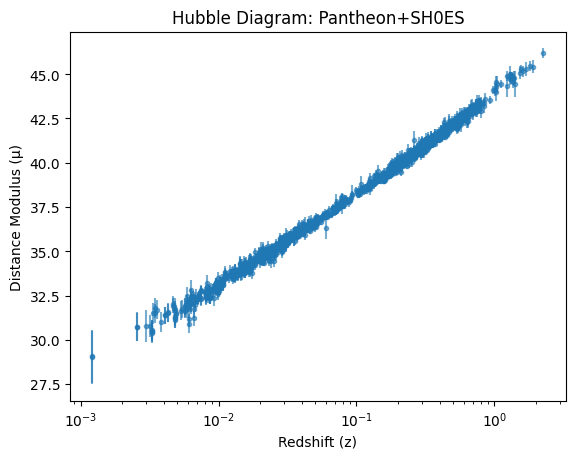

In [ ]:
plt.figure()
plt.errorbar(z, mu, yerr=mu_err, fmt='.', alpha=0.6)
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram: Pantheon+SH0ES')
plt.show()

## 🧮 Define the Cosmological Model

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model (read about the model in wikipedia if needed). This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [ ]:
# Define the E(z) for flat LCDM
# Dimensionless Hubble parameter for flat ΛCDM
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1.0 - Omega_m))

In [ ]:
# Luminosity distance in Mpc, try using scipy quad to integrate.
def luminosity_distance(z, H0, Omega_m):

    if not hasattr(H0, 'unit'):   # Ensure H0 is a Quantity with units km/s/Mpc
        H0 = H0 * (u.km / u.s / u.Mpc)

    c_km_s = c.to(u.km / u.s)  # Speed of light in km/s
    factor = (c_km_s / H0).to(u.Mpc)  # Prefactor c/H0 has units of Mpc

    def integrand(zp):
        return 1.0 / E(zp, Omega_m)

    # Integrate for comoving distance
    if np.isscalar(z):
        Dc = factor * quad(integrand, 0, z)[0]
    else:
        Dc = np.array([quad(integrand, 0, zi)[0] for zi in z]) * factor

    D_L = (1 + z) * Dc # Luminosity distance D_L = (1+z) * D_C
    return D_L.to(u.Mpc)

In [ ]:
# Theoretical distance modulus
def mu_theory(z, H0, Omega_m):
    D_L = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(D_L.value) + 25   # Convert to dimensionless for log10

## 🔧 Fit the Model to Supernova Data

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


In [ ]:
# Initial guess: H0 = 70 km/s/Mpc, Omega_m = 0.3
p0 = [70, 0.3]

In [ ]:
# Fit mu_theory(z, H0, Omega_m) to the data
popt, pcov = curve_fit(
    mu_theory,
    z, mu,
    sigma=mu_err,
    p0=p0,
    absolute_sigma=True,
    maxfev=5000
)

In [ ]:
# Extract best‐fit parameters and their 1σ uncertainties
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


## ⏳ Estimate the Age of the Universe

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [ ]:
def age_of_universe(H0, Omega_m):
    H0_si = (H0 * u.km / u.s / u.Mpc).to(1 / u.s)  # Convert H0 [km/s/Mpc] to s⁻¹
    integral = quad(lambda z: 1.0 / ((1 + z) * E(z, Omega_m)), 0, np.inf, limit=200)[0]
    t0_sec = integral / H0_si.value  # Age in seconds = integral / H0_si
    return (t0_sec * u.s).to(u.Gyr).value # Convert to gigayears

In [ ]:
t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr


## 📊 Analyze Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


In [ ]:
mu_pred = mu_theory(z, H0_fit * u.km/u.s/u.Mpc, Omega_m_fit)
residuals = mu - mu_pred

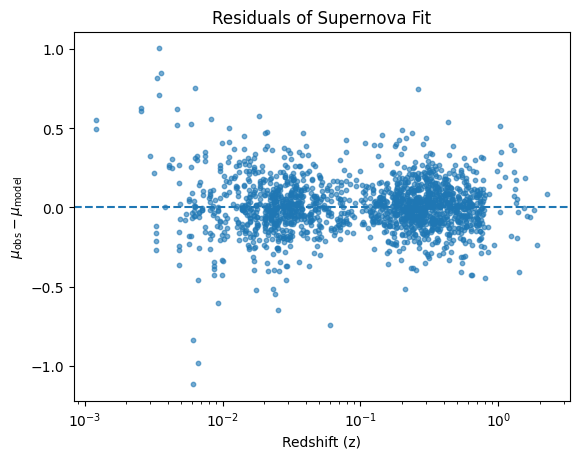

In [ ]:
# Plot residuals vs. redshift
plt.figure()
plt.scatter(z, residuals, s=10, alpha=0.6)
plt.xscale('log')
plt.axhline(0, linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\mu_{\rm obs} - \mu_{\rm model}$')
plt.title('Residuals of Supernova Fit')
plt.show()

## 🔧 Fit with Fixed Matter Density

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [ ]:
# Fix Omega_m = 0.3, fit only H0
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

In [ ]:
# Perform the fit
popt, pcov = curve_fit(
    mu_fixed_Om,
    z, mu,
    sigma=mu_err,
    p0=[70],
    absolute_sigma=True,
    maxfev=5000
)

In [ ]:
# Extract result
H0_fixed, = popt
H0_fixed_err, = np.sqrt(np.diag(pcov))

print(f"Fixed Ωm=0.3 → H0 = {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

Fixed Ωm=0.3 → H0 = 73.53 ± 0.17 km/s/Mpc


Checking with other fixed values of $ \Omega_m $

In [ ]:
omega_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
results = []

In [ ]:
for Om in omega_values:
    # Define model with Ωₘ fixed
    def mu_fixed(z, H0):
        return mu_theory(z, H0, Omega_m=Om)

    # Fit for H0
    popt, pcov = curve_fit(
        mu_fixed,
        z, mu,
        sigma=mu_err,
        p0=[70],
        absolute_sigma=True,
        maxfev=5000
    )
    H0_fit = popt[0]
    H0_err = np.sqrt(pcov[0,0])

    # Compute age of universe for this (H0, Om)
    t0 = age_of_universe(H0_fit, Om)

    results.append((Om, H0_fit, H0_err, t0))
    print(f"Ωₘ = {Om:.2f} -> H₀ = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc, Age = {t0:.2f} Gyr")

Ωₘ = 0.10 -> H₀ = 76.03 ± 0.18 km/s/Mpc, Age = 16.44 Gyr
Ωₘ = 0.15 -> H₀ = 75.35 ± 0.18 km/s/Mpc, Age = 15.03 Gyr
Ωₘ = 0.20 -> H₀ = 74.71 ± 0.17 km/s/Mpc, Age = 14.08 Gyr
Ωₘ = 0.25 -> H₀ = 74.10 ± 0.17 km/s/Mpc, Age = 13.38 Gyr
Ωₘ = 0.30 -> H₀ = 73.53 ± 0.17 km/s/Mpc, Age = 12.82 Gyr
Ωₘ = 0.35 -> H₀ = 72.98 ± 0.17 km/s/Mpc, Age = 12.37 Gyr
Ωₘ = 0.40 -> H₀ = 72.46 ± 0.17 km/s/Mpc, Age = 11.98 Gyr
Ωₘ = 0.45 -> H₀ = 71.96 ± 0.17 km/s/Mpc, Age = 11.65 Gyr
Ωₘ = 0.50 -> H₀ = 71.48 ± 0.17 km/s/Mpc, Age = 11.37 Gyr


## 🔍 Compare Low-z and High-z Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [ ]:
# Redshift split threshold
z_split = 0.1

# Masks for low-z and high-z samples
mask_low  = z <  z_split
mask_high = z >= z_split

In [ ]:
# Fit low-z subsample
popt_low, pcov_low = curve_fit(
    mu_fixed_Om,
    z[mask_low],
    mu[mask_low],
    sigma=mu_err[mask_low],
    p0=[70],
    absolute_sigma=True,
    maxfev=5000
)

H0_low     = popt_low[0]
H0_low_err = np.sqrt(pcov_low[0,0])

In [ ]:
# Fit high-z subsample
popt_high, pcov_high = curve_fit(
    mu_fixed_Om,
    z[mask_high],
    mu[mask_high],
    sigma=mu_err[mask_high],
    p0=[70],
    absolute_sigma=True,
    maxfev=5000
)

H0_high     = popt_high[0]
H0_high_err = np.sqrt(pcov_high[0,0])

In [32]:
t0_low  = age_of_universe(H0_low,  0.3)
t0_high = age_of_universe(H0_high, 0.3)

print(f"Low-z sample → H₀ = {H0_low:.2f} km/s/Mpc, Age = {t0_low:.2f} Gyr")
print(f"High-z sample → H₀ = {H0_high:.2f} km/s/Mpc, Age = {t0_high:.2f} Gyr")

Low-z sample → H₀ = 73.01 km/s/Mpc, Age = 12.91 Gyr
High-z sample → H₀ = 73.85 km/s/Mpc, Age = 12.77 Gyr


In [33]:
omega_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
z_split = 0.1
mask_low  = z <  z_split
mask_high = z >= z_split

In [41]:
print("Ωₘ   |  H₀_low ± err  | Age_low (Gyr) |  H₀_high ± err | Age_high (Gyr)")
print("-----|----------------|---------------|----------------|--------------")

for Om in omega_values:
    # Fit H₀ for low-z with Ωₘ fixed
    def mu_low(z_vals, H0):
        return mu_theory(z_vals, H0, Omega_m=Om)
    p_low, cov_low = curve_fit(mu_low,
                                z[mask_low], mu[mask_low],
                                sigma=mu_err[mask_low],
                                p0=[70],
                                absolute_sigma=True,
                                maxfev=5000)
    H0_low, H0_low_err = p_low[0], np.sqrt(cov_low[0,0])
    t0_low = age_of_universe(H0_low, Om)

    # Fit H₀ for high-z with Ωₘ fixed
    def mu_high(z_vals, H0):
        return mu_theory(z_vals, H0, Omega_m=Om)
    p_high, cov_high = curve_fit(mu_high,
                                 z[mask_high], mu[mask_high],
                                 sigma=mu_err[mask_high],
                                 p0=[70],
                                 absolute_sigma=True,
                                 maxfev=5000)
    H0_high, H0_high_err = p_high[0], np.sqrt(cov_high[0,0])
    t0_high = age_of_universe(H0_high, Om)
    print(f"{Om:>4.2f} | {H0_low:6.2f} ± {H0_low_err:<5.2f} | {t0_low:13.2f} | "f"{H0_high:6.2f} ± {H0_high_err:<5.2f} | {t0_high:13.2f}")

Ωₘ   |  H₀_low ± err  | Age_low (Gyr) |  H₀_high ± err | Age_high (Gyr)
-----|----------------|---------------|----------------|--------------
0.10 |  73.39 ± 0.28  |         17.03 |  77.67 ± 0.23  |         16.09
0.15 |  73.29 ± 0.28  |         15.45 |  76.62 ± 0.23  |         14.78
0.20 |  73.20 ± 0.28  |         14.37 |  75.64 ± 0.22  |         13.91
0.25 |  73.10 ± 0.28  |         13.56 |  74.72 ± 0.22  |         13.27
0.30 |  73.01 ± 0.28  |         12.91 |  73.85 ± 0.22  |         12.77
0.35 |  72.91 ± 0.28  |         12.38 |  73.03 ± 0.22  |         12.36
0.40 |  72.82 ± 0.28  |         11.92 |  72.24 ± 0.21  |         12.02
0.45 |  72.73 ± 0.28  |         11.53 |  71.50 ± 0.21  |         11.73
0.50 |  72.63 ± 0.28  |         11.19 |  70.79 ± 0.21  |         11.48


You can check your results and potential reasons for different values from accepted constant using this paper by authors of the [Pantheon+ dataset](https://arxiv.org/pdf/2310.11727)

You can find more about the dataset in the paper too